In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [2]:
random.seed = 20

## Load model

In [3]:
from GNNPGRegressor import PGSAGE, PGANN, PGGCN
from MyDataset import MyDataset
from CustomLoss import CustomLoss

custom_loss = CustomLoss()

## Set parameters

In [4]:
# Set hyper-parameters
input_dim1 = 32
input_dim2 = 44
hidden_dim1 = 32
hidden_dim2 = 32
output_dim1 = 32
output_dim2 = 12

# Set device
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

## ANN

In [5]:
root = '../../train_val_test_dataset/IEEE_Case118/PG-ANN'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
train_size = 700

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model
model = PGANN(input_dim1, input_dim2, hidden_dim1, hidden_dim2, output_dim1, output_dim2)
model.to(device)

PGANN(
  (encoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (ann): Sequential(
    (0): Linear(in_features=44, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
)

#### ANN model training

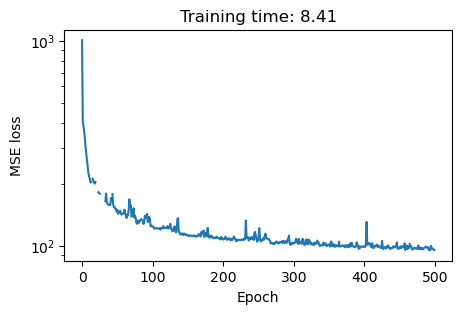

In [6]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index)

        # loss = F.mse_loss(y_pred, loader.y)
        loss = custom_loss(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save ANN model

In [7]:
torch.save(model, './trained_model/PGANN_model.pt')

#### ANN model testing

In [9]:
model_path = './trained_model/PGANN_model.pt'
model = torch.load(model_path)

model.eval()

# Testing dataset 
# Get test dataset
test_size = 200
test_dataset = dataset[-test_size:]
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()
        # Save ground true
        file_path = f'./model_evaluation/ANN/PG_true/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = pred.detach().numpy()

        ############ Add postprocessing ##############
        pred[pred<25] = 0

        # Save prediction
        file_path = f'./model_evaluation/ANN/PG_pred/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)


# Complete dataset
test_dataset = dataset[:]
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()
        # Save ground true
        file_path = f'./model_evaluation/ANN/PG_true_all/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = pred.detach().numpy()

        ############ Add postprocessing ##############
        pred[pred<25] = 0

        # Save prediction
        file_path = f'./model_evaluation/ANN/PG_pred_all/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)

## SAGE

In [10]:
root = '../../train_val_test_dataset/IEEE_Case118/PG-SAGE'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
train_size = 700

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model
model = PGSAGE(input_dim1, input_dim2, hidden_dim1, hidden_dim2, output_dim1, output_dim2)
model.to(device)

PGSAGE(
  (encoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (gnn): Sequential(
    (0): SAGEConv(44, 32, aggr=mean)
    (1): ReLU()
    (2): SAGEConv(32, 32, aggr=mean)
    (3): ReLU()
    (4): SAGEConv(32, 12, aggr=mean)
  )
)

#### SAGE model training

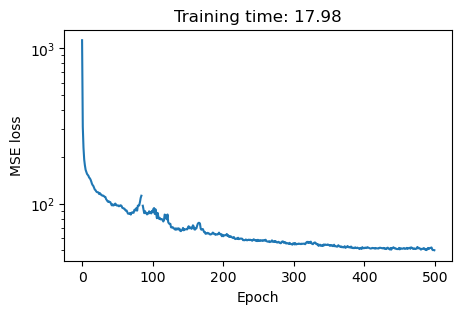

In [11]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index)

        # loss = F.mse_loss(y_pred, loader.y)
        loss = custom_loss(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save SAGE model

In [12]:
torch.save(model, './trained_model/PGSAGE_model.pt')

#### SAGE model testing

In [13]:
model_path = './trained_model/PGSAGE_model.pt'
model = torch.load(model_path)

model.eval()

# Testing dataset 
# Get test dataset
test_size = 200
test_dataset = dataset[-test_size:]
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()
        # Save ground true
        file_path = f'./model_evaluation/SAGE/PG_true/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = pred.detach().numpy()

        ############ Add postprocessing ##############
        pred[pred<25] = 0

        # Save prediction
        file_path = f'./model_evaluation/SAGE/PG_pred/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)


# Complete dataset
test_dataset = dataset[:]
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()
        # Save ground true
        file_path = f'./model_evaluation/SAGE/PG_true_all/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = pred.detach().numpy()

        ############ Add postprocessing ##############
        pred[pred<25] = 0

        # Save prediction
        file_path = f'./model_evaluation/SAGE/PG_pred_all/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)

## GCN

In [14]:
root = '../../train_val_test_dataset/IEEE_Case118/PG-GCN'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
train_size = 700

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize the model
model = PGGCN(input_dim1, input_dim2, hidden_dim1, hidden_dim2, output_dim1, output_dim2)
model.to(device)

PGGCN(
  (encoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (gnn): Sequential(
    (0): GCNConv(44, 32)
    (1): ReLU()
    (2): GCNConv(32, 32)
    (3): ReLU()
    (4): GCNConv(32, 12)
  )
)

#### GCN model training

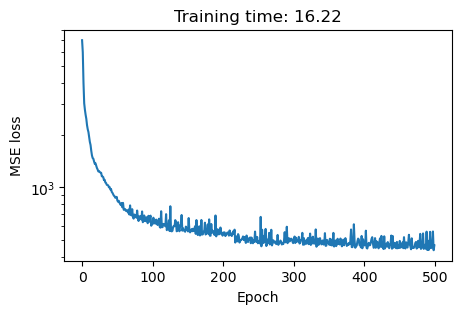

In [15]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index)

        # loss = F.mse_loss(y_pred, loader.y)
        loss = custom_loss(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save GCN model

In [16]:
torch.save(model, './trained_model/PGGCN_model.pt')

#### GCN model testing

In [17]:
model_path = './trained_model/PGGCN_model.pt'
model = torch.load(model_path)

model.eval()

# Testing dataset 
# Get test dataset
test_size = 200
test_dataset = dataset[-test_size:]
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()
        # Save ground true
        file_path = f'./model_evaluation/GCN/PG_true/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = pred.detach().numpy()

        ############ Add postprocessing ##############
        pred[pred<25] = 0

        # Save prediction
        file_path = f'./model_evaluation/GCN/PG_pred/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)


# Complete dataset
test_dataset = dataset[:]
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()
        # Save ground true
        file_path = f'./model_evaluation/GCN/PG_true_all/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = pred.detach().numpy()

        ############ Add postprocessing ##############
        pred[pred<25] = 0

        # Save prediction
        file_path = f'./model_evaluation/GCN/PG_pred_all/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)